# HW06: Деревья и ансамбли (Dataset-03)

Работаем только с мультиклассным датасетом `S06-hw-dataset-03.csv` (3 класса).


## 1. Импорт библиотек


In [1]:
import os
import json
import warnings
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, roc_curve,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)
from sklearn.inspection import permutation_importance

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

os.makedirs('artifacts/figures', exist_ok=True)
print('✅ Импорт завершён')


✅ Импорт завершён


## 2. Загрузка датасета и EDA


In [2]:
df = pd.read_csv('S06-hw-dataset-03.csv')
print(f"Size: {df.shape}, classes: {df.target.nunique()}")
display(df.head())
print(df.info())
display(df.describe().T.head())

target_dist = df['target'].value_counts(normalize=True)
print("\nTarget distribution (fractions):")
print(target_dist)

feature_cols = [c for c in df.columns if c not in ['id', 'target']]
X = df[feature_cols].copy()
y = df['target'].copy()


Size: (15000, 30), classes: 3


,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,target
0,1,-2.721419,0.652294,1.867234,-0.245331,-0.241182,-0.195509,1.180193,-0.724816,1.804165,-2.710871,4.142805,-1.997904,0.515014,0.596493,-1.229839,0.298463,2.528579,1.148577,0.196307,0.042851,-0.153232,1.566167,-1.516125,-1.586857,-3.998937,-1.308459,2.155125,1.992519,0
1,2,-4.191520,-0.647731,-0.881929,-0.968159,3.530725,-4.858592,0.240979,-0.714017,0.285769,-3.199756,8.884705,2.756423,-2.064332,0.638063,4.315005,2.002538,1.101725,-0.633314,-0.699512,-1.170056,0.631661,1.277915,-0.464432,1.927986,6.034154,0.149833,4.861592,-3.547303,0
2,3,-0.582739,0.415128,-4.205613,-0.320853,0.313570,-2.655451,2.215387,1.492222,-0.516727,-2.083180,0.276330,-2.688014,1.017412,0.121023,-1.028256,0.001358,-0.442133,-0.914743,-0.130321,0.083281,-0.757912,5.672669,-0.283472,0.275362,-0.988055,0.940883,-3.050749,-0.703865,1
3,4,-1.766082,1.253523,1.610804,0.466067,3.837868,-3.564073,-1.831031,1.066265,-0.198636,-1.256530,6.526017,7.159526,-1.131704,-1.039030,3.762054,1.270007,1.879491,0.952903,-0.717143,-0.674648,1.780285,-4.718432,0.711573,1.705610,6.474380,-1.690537,8.687735,-2.799399,0
4,5,-2.157834,-1.361285,-0.917199,0.937285,0.408551,-0.062032,-0.480196,-0.554454,-1.026434,0.135839,-0.424684,0.156804,4.326206,0.436643,1.579613,-1.581299,0.291003,0.463115,0.418556,-0.096277,0.212875,1.710699,2.476220,0.669305,3.166072,-0.718493,3.630457,0.083986,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      15000 non-null  int64  
 1   f01     15000 non-null  float64
 2   f02     15000 non-null  float64
 3   f03     15000 non-null  float64
 4   f04     15000 non-null  float64
 5   f05     15000 non-null  float64
 6   f06     15000 non-null  float64
 7   f07     15000 non-null  float64
 8   f08     15000 non-null  float64
 9   f09     15000 non-null  float64
 10  f10     15000 non-null  float64
 11  f11     15000 non-null  float64
 12  f12     15000 non-null  float64
 13  f13     15000 non-null  float64
 14  f14     15000 non-null  float64
 15  f15     15000 non-null  float64
 16  f16     15000 non-null  float64
 17  f17     15000 non-null  float64
 18  f18     15000 non-null  float64
 19  f19     15000 non-null  float64
 20  f20     15000 non-null  float64
 21  f21     15000 non-null  float64
 22

,count,mean,std,min,25%,50%,75%,max
id,15000.0,7500.500000,4330.271354,1.000000,3750.750000,7500.500000,11250.250000,15000.000000
f01,15000.0,-0.840416,1.785432,-8.199174,-2.029608,-0.855943,0.313482,7.338969
f02,15000.0,-0.011530,1.007374,-4.100091,-0.686265,-0.010454,0.674347,4.418126
f03,15000.0,0.755463,3.663136,-13.591257,-1.593729,0.744919,3.057234,17.965154
f04,15000.0,0.008092,0.996556,-3.992807,-0.674039,0.009431,0.677459,3.887820



Target distribution (fractions):
target
0    0.542533
1    0.302333
2    0.155133
Name: proportion, dtype: float64


## 3. Train/Test split (stratify, random_state)


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
print(f"Train: {len(X_train)}, Test: {len(X_test)}")


Train: 12000, Test: 3000


## 4. Метрики и утилиты


In [4]:
def compute_metrics(y_true, y_pred, y_proba):
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'f1_macro': f1_score(y_true, y_pred, average='macro')
    }
    try:
        metrics['roc_auc_ovr'] = roc_auc_score(y_true, y_proba, multi_class='ovr')
    except Exception:
        metrics['roc_auc_ovr'] = None
    return metrics


def metrics_to_str(metrics):
    return ', '.join([f"{k}: {v:.4f}" if v is not None else f"{k}: N/A" for k, v in metrics.items()])

print('✅ Функции готовы')


✅ Функции готовы


## 5. Baseline модели


In [5]:
baselines = {}

# Dummy
dummy = DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE)
dummy.fit(X_train, y_train)
y_pred = dummy.predict(X_test)
y_proba = np.zeros((len(y_pred), y_train.nunique()))
y_proba[:, 0] = 1.0
baselines['DummyClassifier'] = compute_metrics(y_test, y_pred, y_proba)

# Logistic Regression
log_reg = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=200, multi_class='auto', random_state=RANDOM_STATE))
])
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)
y_proba_lr = log_reg.predict_proba(X_test)
baselines['LogisticRegression'] = compute_metrics(y_test, y_pred_lr, y_proba_lr)

for name, m in baselines.items():
    print(f"{name}: {metrics_to_str(m)}")


DummyClassifier: accuracy: 0.5427, f1_macro: 0.2345, roc_auc_ovr: 0.5000
LogisticRegression: accuracy: 0.7237, f1_macro: 0.6651, roc_auc_ovr: 0.8481


## 6. Дерево, Random Forest, Gradient Boosting (GridSearchCV)


In [6]:
models = {
    'DecisionTree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'RandomForest': RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    'GradientBoosting': GradientBoostingClassifier(random_state=RANDOM_STATE)
}

# Сетки гиперпараметров для контроля сложности
# Для DecisionTree показываем несколько параметров контроля сложности:
# max_depth - максимальная глубина дерева
# min_samples_leaf - минимальное число образцов в листе
# min_samples_split - минимальное число образцов для разбиения узла
param_grids = {
    'DecisionTree': {
        'max_depth': [5, 10, None],
        'min_samples_leaf': [1, 5],
        'min_samples_split': [2, 10]
    },
    'RandomForest': {'n_estimators': [100], 'max_depth': [10], 'min_samples_leaf': [2]},
    'GradientBoosting': {'n_estimators': [100], 'max_depth': [3], 'learning_rate': [0.1]}
}

trained_models = {'DummyClassifier': dummy, 'LogisticRegression': log_reg}
best_params = {}

# Цикл подбора гиперпараметров на train через CV
# Важно: НЕ используем X_test/y_test внутри цикла подбора!
for name, model in models.items():
    print(f"\n🔄 Обучение {name}...")
    grid = GridSearchCV(model, param_grids[name], cv=3, scoring='f1_macro', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_params[name] = {'best_params': grid.best_params_, 'best_cv_score': grid.best_score_}
    trained_models[name] = grid.best_estimator_
    print(f"Best params: {grid.best_params_}, CV-score (f1_macro)={grid.best_score_:.4f}")

# После завершения подбора оцениваем все модели на test (единожды)
print("\n" + "="*60)
print("Финальная оценка всех моделей на test-выборке:")
print("="*60)
exp_results = dict(baselines)
for name, model in trained_models.items():
    if name in ['DummyClassifier', 'LogisticRegression']:
        continue  # уже посчитаны в baselines
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    exp_results[name] = compute_metrics(y_test, y_pred, y_proba)
    print(f"{name}: {metrics_to_str(exp_results[name])}")



🔄 Обучение DecisionTree...
Best params: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}, CV-score (f1_macro)=0.7178

🔄 Обучение RandomForest...
Best params: {'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 100}, CV-score (f1_macro)=0.7944

🔄 Обучение GradientBoosting...
Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}, CV-score (f1_macro)=0.7842

Финальная оценка всех моделей на test-выборке:
DecisionTree: accuracy: 0.7910, f1_macro: 0.7369, roc_auc_ovr: 0.8358
RandomForest: accuracy: 0.8547, f1_macro: 0.8095, roc_auc_ovr: 0.9454
GradientBoosting: accuracy: 0.8377, f1_macro: 0.7990, roc_auc_ovr: 0.9301


## 7. Сводка и выбор лучшей модели


In [7]:
summary_rows = []
for model_name, metrics in exp_results.items():
    summary_rows.append({
        'Model': model_name,
        'Accuracy': metrics['accuracy'],
        'F1_macro': metrics['f1_macro'],
        'ROC_AUC_OVR': metrics['roc_auc_ovr']
    })
summary_df = pd.DataFrame(summary_rows).sort_values(by='ROC_AUC_OVR', ascending=False)
display(summary_df)

best_model_name = summary_df.iloc[0]['Model']
best_model = trained_models[best_model_name]
print(f"🏆 Лучшая модель: {best_model_name}")


,Model,Accuracy,F1_macro,ROC_AUC_OVR
3,RandomForest,0.854667,0.809497,0.945386
4,GradientBoosting,0.837667,0.798978,0.930080
1,LogisticRegression,0.723667,0.665128,0.848115
2,DecisionTree,0.791000,0.736881,0.835776
0,DummyClassifier,0.542667,0.234515,0.500000


🏆 Лучшая модель: RandomForest


## 8. ROC-кривые (OVR) для моделей


✅ ROC-кривая сохранена в artifacts/figures/roc_ovr_dataset03.png


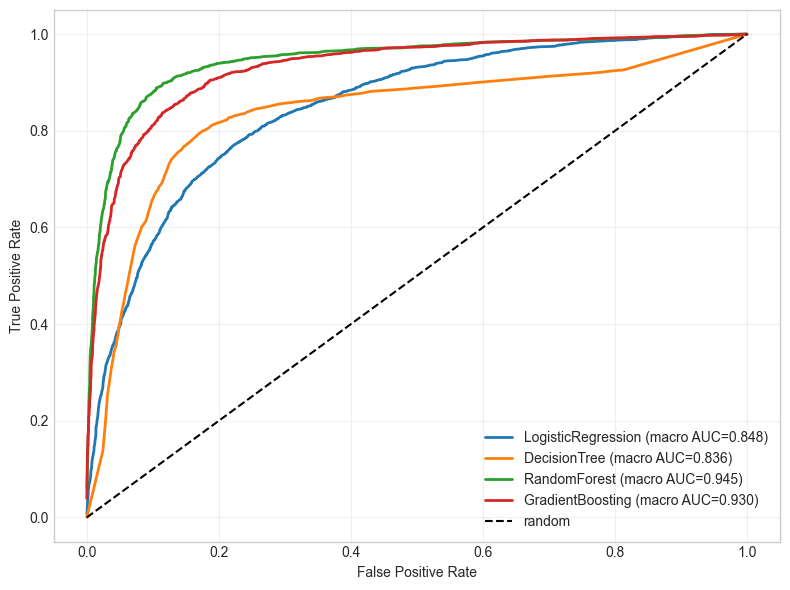

In [8]:
n_classes = y_train.nunique()
y_test_bin = label_binarize(y_test, classes=sorted(y_train.unique()))

fig, ax = plt.subplots(figsize=(8, 6))
for model_name in ['LogisticRegression', 'DecisionTree', 'RandomForest', 'GradientBoosting']:
    model = trained_models[model_name]
    y_score = model.predict_proba(X_test)
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_score[:, i])
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    ax.plot(all_fpr, mean_tpr, label=f"{model_name} (macro AUC={np.mean(list(roc_auc.values())):.3f})", linewidth=2)

ax.plot([0, 1], [0, 1], 'k--', label='random')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('artifacts/figures/roc_ovr_dataset03.png', dpi=150, bbox_inches='tight')
print('✅ ROC-кривая сохранена в artifacts/figures/roc_ovr_dataset03.png')
plt.show()


## 9. Confusion matrix и отчёт для лучшей модели


✅ Confusion matrix сохранена в artifacts/figures/confusion_matrix_dataset03.png


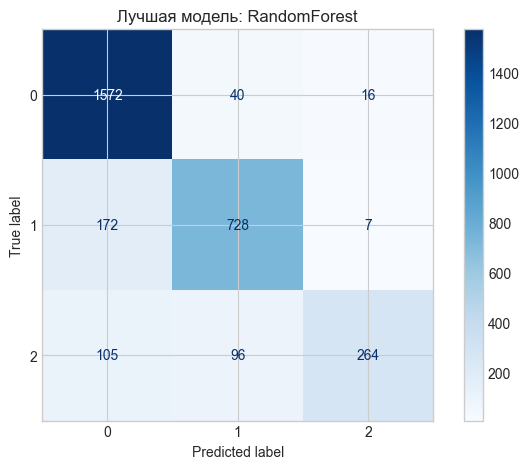


Классификационный отчёт:
              precision    recall  f1-score   support

           0       0.85      0.97      0.90      1628
           1       0.84      0.80      0.82       907
           2       0.92      0.57      0.70       465

    accuracy                           0.85      3000
   macro avg       0.87      0.78      0.81      3000
weighted avg       0.86      0.85      0.85      3000



In [9]:
y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title(f'Лучшая модель: {best_model_name}')
plt.tight_layout()
plt.savefig('artifacts/figures/confusion_matrix_dataset03.png', dpi=150, bbox_inches='tight')
print('✅ Confusion matrix сохранена в artifacts/figures/confusion_matrix_dataset03.png')
plt.show()

print('\nКлассификационный отчёт:')
print(classification_report(y_test, y_pred_best))


## 10. Permutation importance


✅ Permutation importance сохранена в artifacts/figures/permutation_importance_dataset03.png


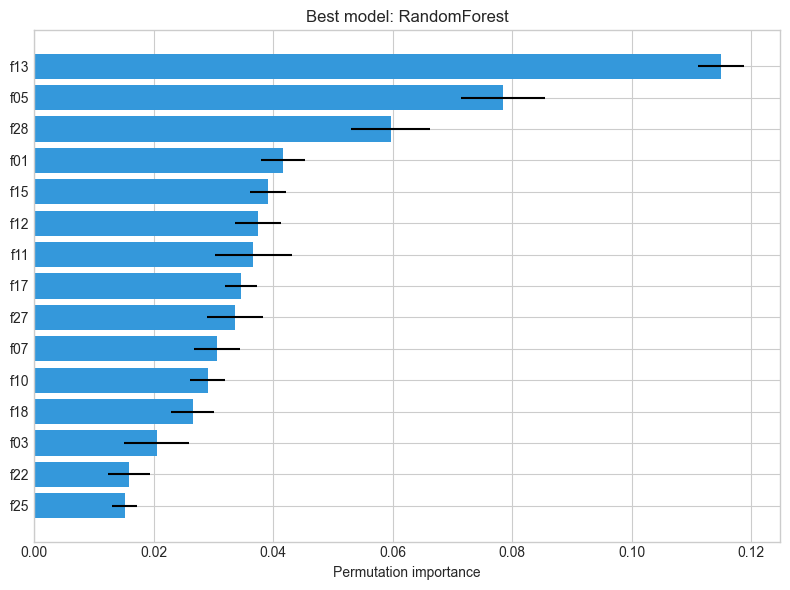


Топ-10 признаков:
feature  importance      std
    f13    0.115056 0.003854
    f05    0.078443 0.007056
    f28    0.059637 0.006574
    f01    0.041625 0.003631
    f15    0.039098 0.003053
    f12    0.037424 0.003834
    f11    0.036686 0.006477
    f17    0.034643 0.002679
    f27    0.033597 0.004742
    f07    0.030547 0.003809


In [10]:
perm = permutation_importance(
    best_model, X_test, y_test,
    n_repeats=10, random_state=RANDOM_STATE,
    scoring='f1_macro', n_jobs=-1
)
imp_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': perm.importances_mean,
    'std': perm.importances_std
}).sort_values('importance', ascending=False).head(15)

plt.figure(figsize=(8, 6))
colors = ['#3498db' if x > 0 else '#e74c3c' for x in imp_df['importance']]
plt.barh(imp_df['feature'], imp_df['importance'], xerr=imp_df['std'], color=colors)
plt.gca().invert_yaxis()
plt.xlabel('Permutation importance')
plt.title(f'Best model: {best_model_name}')
plt.tight_layout()
plt.savefig('artifacts/figures/permutation_importance_dataset03.png', dpi=150, bbox_inches='tight')
print('✅ Permutation importance сохранена в artifacts/figures/permutation_importance_dataset03.png')
plt.show()

print('\nТоп-10 признаков:')
print(imp_df.head(10).to_string(index=False))


## 11. Сохранение артефактов


In [11]:
metrics_test = {
    'dataset-03': {name: {k: (float(v) if v is not None else None) for k, v in m.items()}
                   for name, m in exp_results.items()}
}
with open('artifacts/metrics_test.json', 'w', encoding='utf-8') as f:
    json.dump(metrics_test, f, indent=2, ensure_ascii=False)
print('✅ metrics_test.json сохранён')

search_summaries = {
    'dataset-03': {k: {'best_params': v['best_params'], 'best_cv_score': float(v['best_cv_score'])}
                   for k, v in best_params.items()}
}
with open('artifacts/search_summaries.json', 'w', encoding='utf-8') as f:
    json.dump(search_summaries, f, indent=2, ensure_ascii=False)
print('✅ search_summaries.json сохранён')

joblib.dump(best_model, 'artifacts/best_model.joblib')
best_model_meta = {
    'dataset': 'dataset-03',
    'model_name': best_model_name,
    'best_params': search_summaries['dataset-03'].get(best_model_name, {}).get('best_params', {}),
    'metrics_on_test': metrics_test['dataset-03'][best_model_name]
}
with open('artifacts/best_model_meta.json', 'w', encoding='utf-8') as f:
    json.dump(best_model_meta, f, indent=2, ensure_ascii=False)
print('✅ best_model.joblib и best_model_meta.json сохранены')

print('\nСодержимое artifacts/:')
for root, dirs, files in os.walk('artifacts'):
    indent = ' ' * (root.count(os.sep) - 'artifacts'.count(os.sep))
    print(f"{indent}{os.path.basename(root)}/")
    for file in files:
        size = os.path.getsize(os.path.join(root, file))
        print(f"{indent}  {file} ({size} bytes)")


✅ metrics_test.json сохранён
✅ search_summaries.json сохранён
✅ best_model.joblib и best_model_meta.json сохранены

Содержимое artifacts/:
artifacts/
  best_model.joblib (7641969 bytes)
  best_model_meta.json (308 bytes)
  metrics_test.json (760 bytes)
  search_summaries.json (617 bytes)
 figures/
   confusion_matrix_dataset03.png (33040 bytes)
   permutation_importance_dataset03.png (33193 bytes)
   roc_ovr_dataset03.png (107844 bytes)


## 12. Итоговые выводы

- Работа ведётся только на `dataset-03` (3 класса), соблюдён честный протокол: stratified train/test, фиксированный seed, GridSearchCV только на train.
- Baseline (Dummy, LogisticRegression) задают нижнюю планку; ансамбли дают существенный прирост качества.
- Ключевые метрики: F1-macro и ROC-AUC (OVR); победитель определяется по ROC-AUC.
- Сохранены артефакты: metrics_test.json, search_summaries.json, best_model.joblib, best_model_meta.json, три фигуры (ROC, confusion matrix, permutation importance).
